# Bias in income prediction - Responsible AI analysis sandbox

### By Gleb Drobkov - BCG Responible AI

## Introduction

#### This notebook analyzes income and political donation data and to understand political leanings & income inequality over time.

Data description details can be found at the link below: <br>
https://docs.google.com/document/d/1RVYKlNVE5pepIYnt645VSrWf_cPOJNBVhoWNKXRbKdk/edit?usp=sharing

Analysis sections of this notebook: <br>
0. Import packages, all standard + BCG RAI tool
1. Read data and apply filters / clean-ups
2. Build MSA-level historical features (DNA)
3. Highlight similarities & diffs vs. US Census
4. Create inequality metrics
5. Create MSA-level model variables
6. Build poltiical leanings model
7. Interpret model drivers and results

## 0. Imports

In [1]:
# Import analysis libraries
import time
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scipy.stats.mstats as mstats

import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble

from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

from seaborn import load_dataset
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import shap

# from notebooks/ directory
import sys, os

# Python settings
pd.set_option('display.max_columns', None)

## 1. Read data and apply filters / clean-ups

In [2]:
def read_in_income(gz_path):
    ## Download input file from BCG Egnyte - RAI folder
    ## https://bcg01.egnyte.com/navigate/folder/881ba5c2-8f6e-4eb6-b940-848faa78dee9
    ipums = pd.read_csv(gz_path, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False,
                       usecols = ['INCTOT','AGE','YEAR','MET2013','RACE','HISPAN', 
                     'SERIAL', 'CBSERIAL', 'NUMPREC', 'SUBSAMP', 'HHWT','HHTYPE'])

    # The data contains information about individuals' income, education and demographic background
    return(ipums)

In [3]:
gz_path = './data/usa_00004.csv.gz'

ipums_select = read_in_income(gz_path)

##### Read in donation data - MSA names and ActBlue + WinRed data pulled

In [4]:
def read_in_donations():
    ipums_metro = pd.read_csv('./data/ipums_metro_code_to_name.csv')
    msa_donors = pd.read_csv('./data/MSA_Donor_Stats.csv')

    print(ipums_metro.head(1))
    print(msa_donors.head(1))
    # # 261 unique metro areas
    # # ipums_geo = model_input.merge(ipums_metro, on = 'MET2013')
    
    return ipums_metro, msa_donors

In [5]:
ipums_metro, msa_donors = read_in_donations()

   MET2013 Metropolitan area (2013 OMB delineations)
0        0                  Not in identifiable area
  Short Name                                    MSA  Count of Zipcodes  \
0   New York  New York-Newark-Jersey City, NY-NJ-PA                996   

   Count of People (IPUMS)  Count of Donors Actblue  Count of Donors Winred  \
0                 596438.0                   963056                  161291   

   Sum of Donations Actblue  Sum of Donations Winred  AB % of Total  \
0               304830030.5              28576897.72       0.856547   

   P-Rank Liberal  P-Rank Size  
0           0.924          1.0  


P-Rank Liberal is our target variable for the political leanings model - what drives an MSA to be liberal or conservative, as defined by the ratio of Actblue to Winred donations, relative to the rest of the country.

For more information - see our Tableau dashboard read-along guide here:
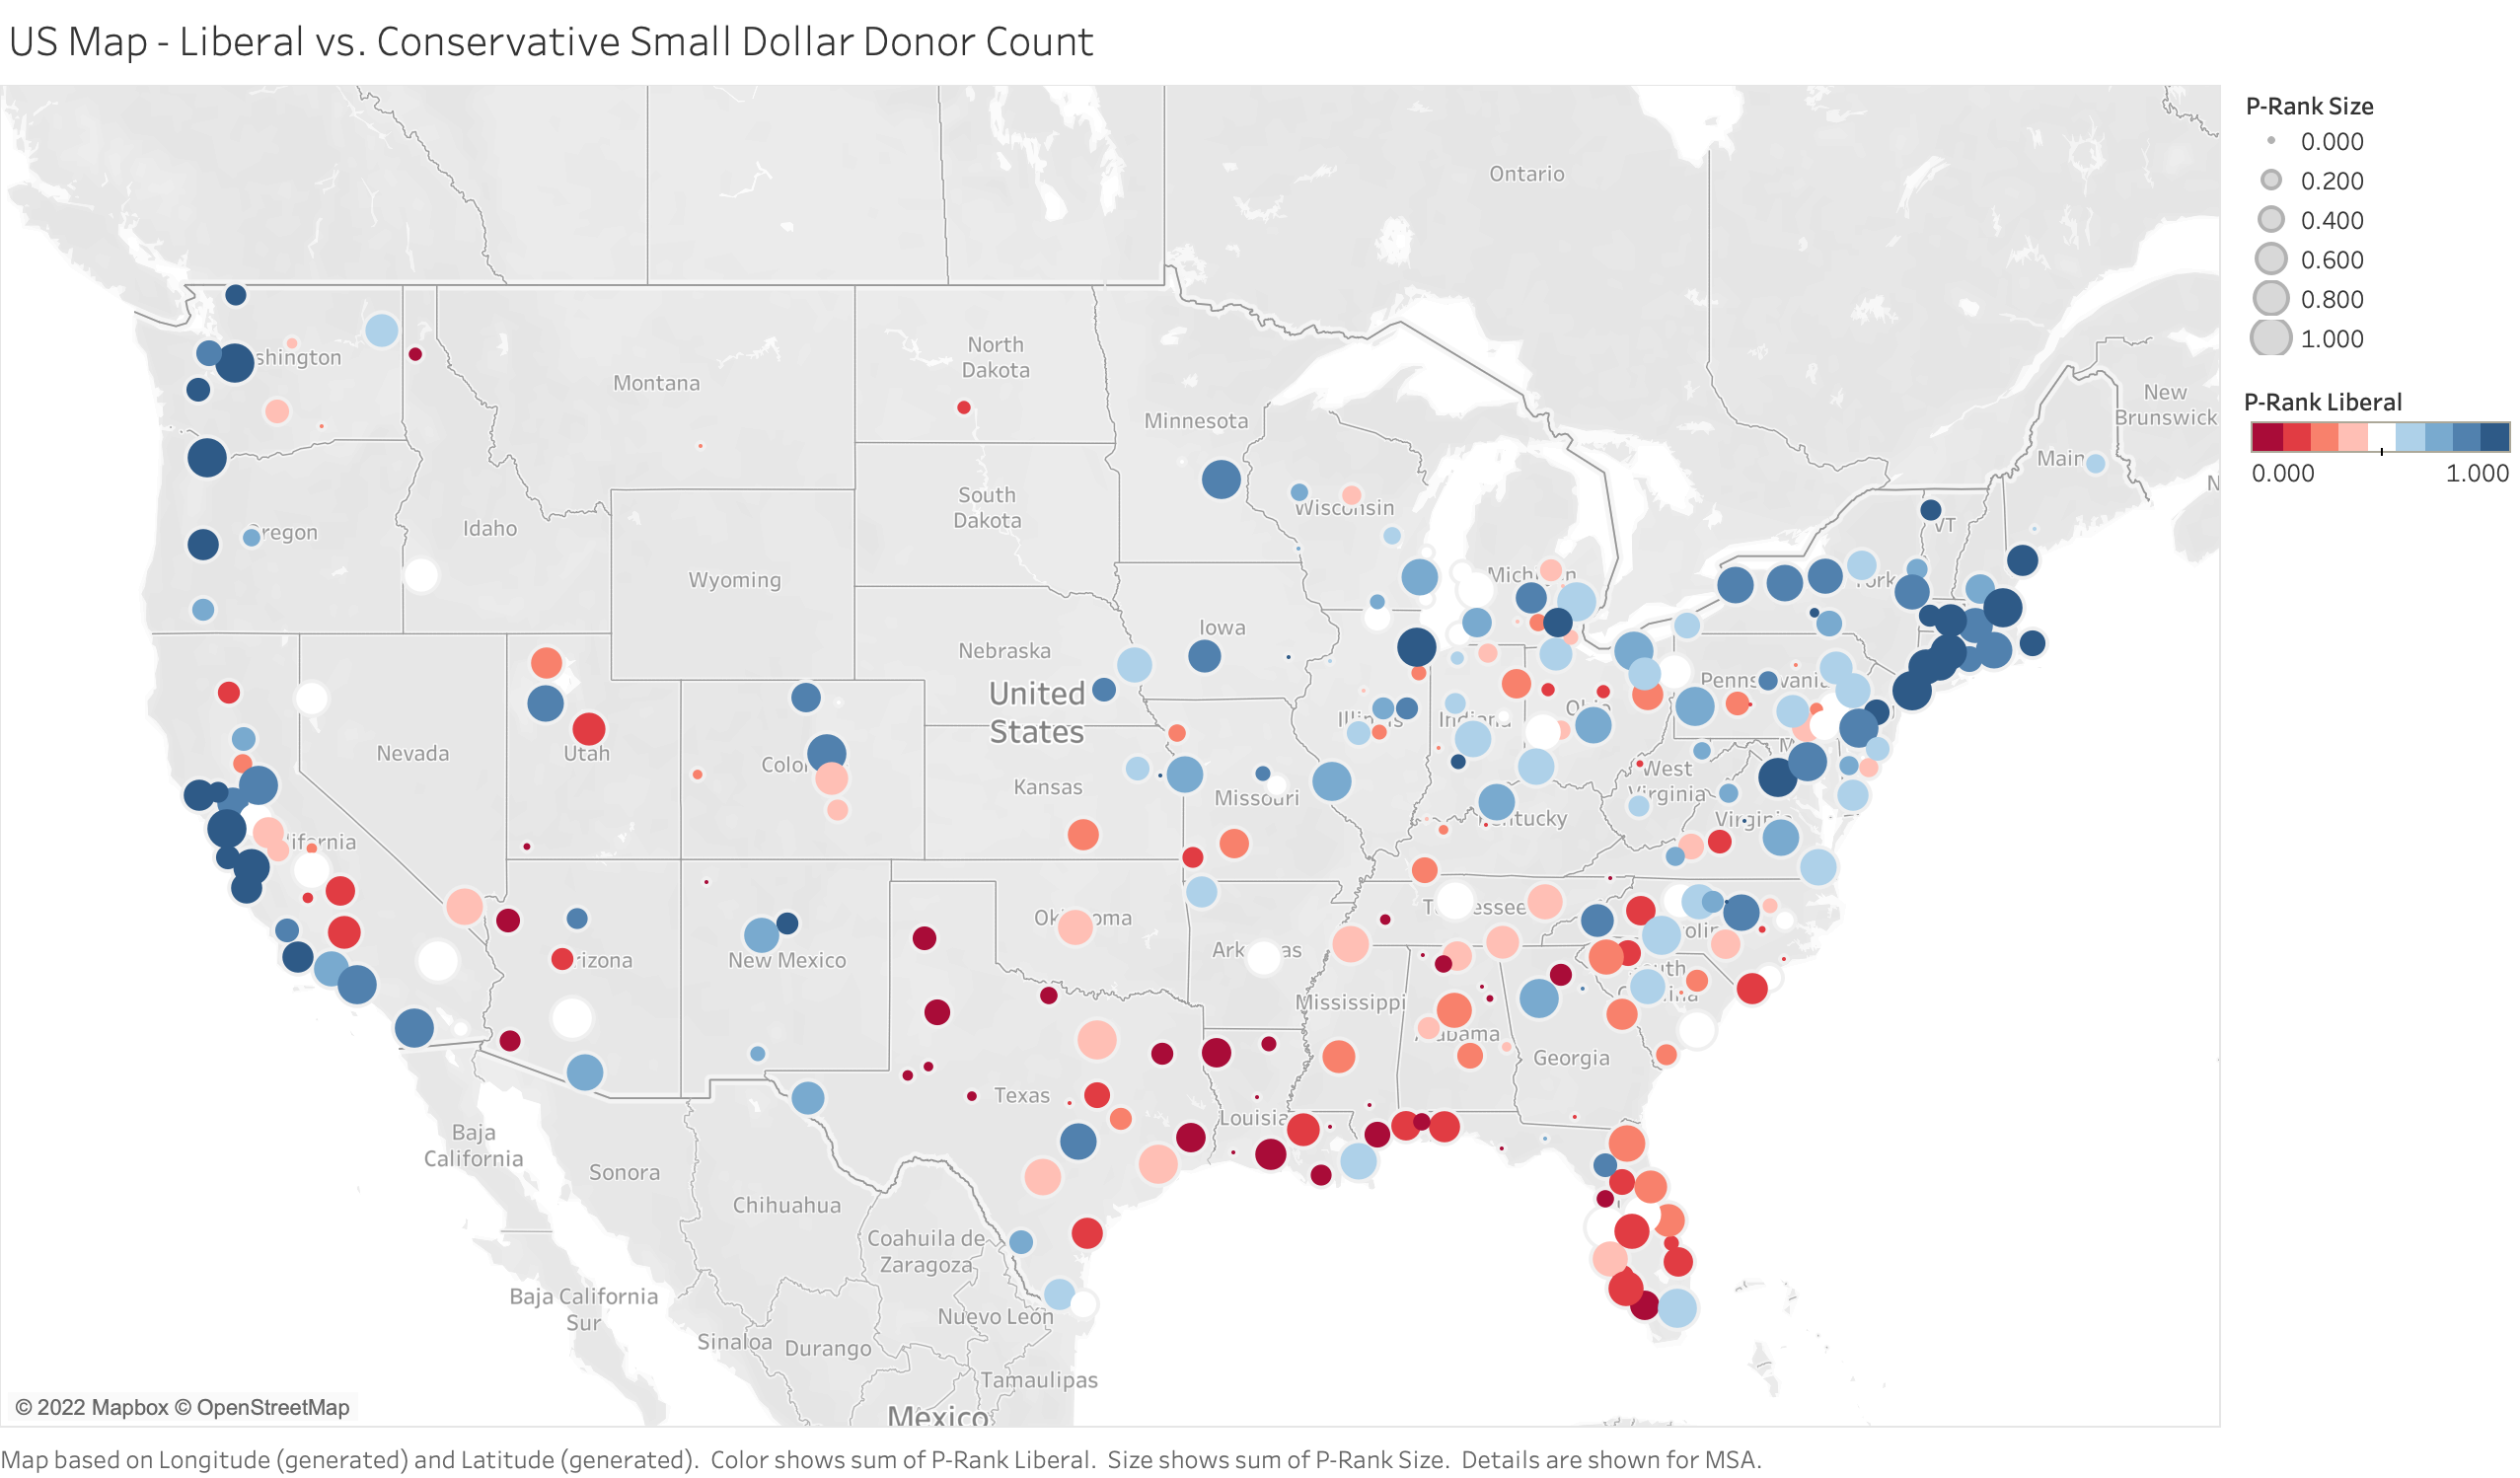

#### Our Hypothesis
We create a historical data set of income, demographics and income inequality at the MSA level over the past 70 years. <br?
We expect to find correlation between income inequality and interest to preserve conservative politial order, when adjusted for other factors such as MSA Age, Size and Income

## 2. Build MSA-level historical features (DNA)

##### Filter down to working age (18-80) records for which we have income

In [6]:
def clean_age_income(model_input):
    
    # Remove Missing values
    # model_input.INCTOT.max()
    # 9999999
    print("Starting individual/year records: ", model_input.shape)
    model_input = model_input[model_input['INCTOT'] != 9999999]
    model_input = model_input[model_input['INCTOT'] > 0]
    print("Removing null income - remaining records: ", model_input.shape)
    # model_input.INCTOT.hist(bins = 50)
    model_input = model_input[model_input['AGE'] > 18]
#     model_input = model_input[model_input['AGE'] < 80]
    print("Removing ages <18 & >80 - remaining records: ", model_input.shape)
    # model_input.AGE.hist(bins = 61)
    
    return(model_input)

#### Some inequality is merited (for ex. by age / tenue) -- we create segments to control for this disparity

In [7]:
def create_age_groupings(model_input):
    #### Group based on US Census race definitions

    # 18-25
    # 26-35
    # 36-45
    # 46-55
    # 56-65
    # 65+

    # by year
    conditions = [
        (model_input.AGE >= 18) & (model_input.AGE < 26), # 1
        (model_input.AGE >= 26) & (model_input.AGE < 36), # 2
        (model_input.AGE >= 36) & (model_input.AGE < 46), # 3
        (model_input.AGE >= 46) & (model_input.AGE < 56), # 4
        (model_input.AGE >= 56) & (model_input.AGE < 66), # 5
        (model_input.AGE >= 66) # 6
    ]

    choices = ['1 - 18-25', '2 - 26-35', '3 - 36-45', 
               '4 - 46-55', '5 - 56-65', '6 - 65+']
    model_input['AGE_Grp'] = np.select(conditions, choices, default='Other Age')
    
    ### Not super representative of the US - skews more white
    print(model_input['AGE_Grp'].value_counts(normalize = True))
    
    return(model_input)

#### Some inequality is driven by historical biases (for ex. by age / tenue) -- we create segments to interrogate this disparity

In [9]:
def create_race_groupings(model_input):
    #### Group based on US Census race definitions

    # Group 1: Asian
    # Group 2: White, not Hispanic
    # Group 3: Hispanic (any race)
    # Group 4: Black

    # by group
    conditions = [
        (model_input.RACE == 4) | (model_input.RACE == 5) | (model_input.RACE == 6),
        (model_input.RACE == 1) & (model_input.HISPAN == 0),
        (model_input.HISPAN == 1),
        (model_input.RACE == 2)
    ]

    choices = ['Asian', 'White not Hispanic', 'Hispanic any race', 'Black']
    model_input['RACE_Grp'] = np.select(conditions, choices, default='Other race')
    model_input['non_white'] = 1 - np.where(model_input['RACE_Grp'] == 'White not Hispanic',1,0)
    model_input['hispanic'] = np.where(model_input['RACE_Grp'] == 'Hispanic any race',1,0)
    model_input['black'] = np.where(model_input['RACE_Grp'] == 'black',1,0)

    ### Not super representative of the US - skews more white
    print(model_input['RACE_Grp'].value_counts(normalize = True))
    
    return(model_input)

#### We also create segments by time, broken into decadeas < 2000, and 4 - year increments post 2000 (when the household survey used by the US Census became annual)

In [10]:
def create_time_groupings(model_input):
    #### Group based on US Census race definitions

    # Groups 1 - 5: Each decade of US Census: 1950 - 1990 
    # Group 6: Early 2000s (2000 - 2007)
    # Group 8: 2008 GFC (2008 - 2011)
    # Group 9: Post-GFC (2012 - 2019)
    # Group 10: Pandemic (2020)

    # by year
    conditions = [
        (model_input.YEAR == 1950),(model_input.YEAR == 1960),(model_input.YEAR == 1970), # 1,2,3
        (model_input.YEAR == 1980),(model_input.YEAR == 1990),(model_input.YEAR == 2000), # 4,5,6
        (model_input.YEAR >= 2001) & (model_input.YEAR < 2008), # 7
        (model_input.YEAR >= 2008) & (model_input.YEAR < 2012), # 8
        (model_input.YEAR >= 2012) & (model_input.YEAR < 2016), # 9
        (model_input.YEAR >= 2016) & (model_input.YEAR < 2020), # 9
        (model_input.YEAR >= 2020) # 11
    ]

    # More verbose
#     choices = ['1 - 1950s', '2 - 1960s', '3 - 1970s', '4 - 1980s', '5 - 1990s', 
#                '6 - 2000 Tech Bubble', '7 - 2004 Pre-GFC', 
#                '8 - 2008 GFC', '9 - 2012 Post-GFC', '9 - 2016 Tech Bubble', 
#                '10 - 2020 Pandemic']
    # More verbose
    choices = [1950,1960, 1970, 1980, 1990, 2000, 2004, 2008, 2012, 2016, 2020]
    model_input['YEAR_Grp'] = np.select(conditions, choices, default='Other period')
    
    ### Not super representative of the US - skews more white
    print(model_input['YEAR_Grp'].value_counts(normalize = True))
    
    return(model_input)

In [11]:
model_input = clean_age_income(ipums_select)

Starting individual/year records:  (109658177, 12)
Removing null income - remaining records:  (59586030, 12)
Removing ages <18 & >80 - remaining records:  (57330998, 12)


In [12]:
model_input = create_age_groupings(model_input)

6 - 65+      0.204071
4 - 46-55    0.182045
3 - 36-45    0.178469
2 - 26-35    0.165510
5 - 56-65    0.158116
1 - 18-25    0.111789
Name: AGE_Grp, dtype: float64


In [13]:
model_input = create_race_groupings(model_input)

White not Hispanic    0.758377
Black                 0.094578
Other race            0.055114
Hispanic any race     0.054896
Asian                 0.037034
Name: RACE_Grp, dtype: float64


In [14]:
model_input = create_time_groupings(model_input)

2000    0.165654
2004    0.162298
2016    0.158322
2012    0.152050
2008    0.147077
1960    0.088700
1970    0.036817
2020    0.032961
1990    0.028485
1980    0.024029
1950    0.003607
Name: YEAR_Grp, dtype: float64


## 3. Highlight similarities & diffs vs. US Census

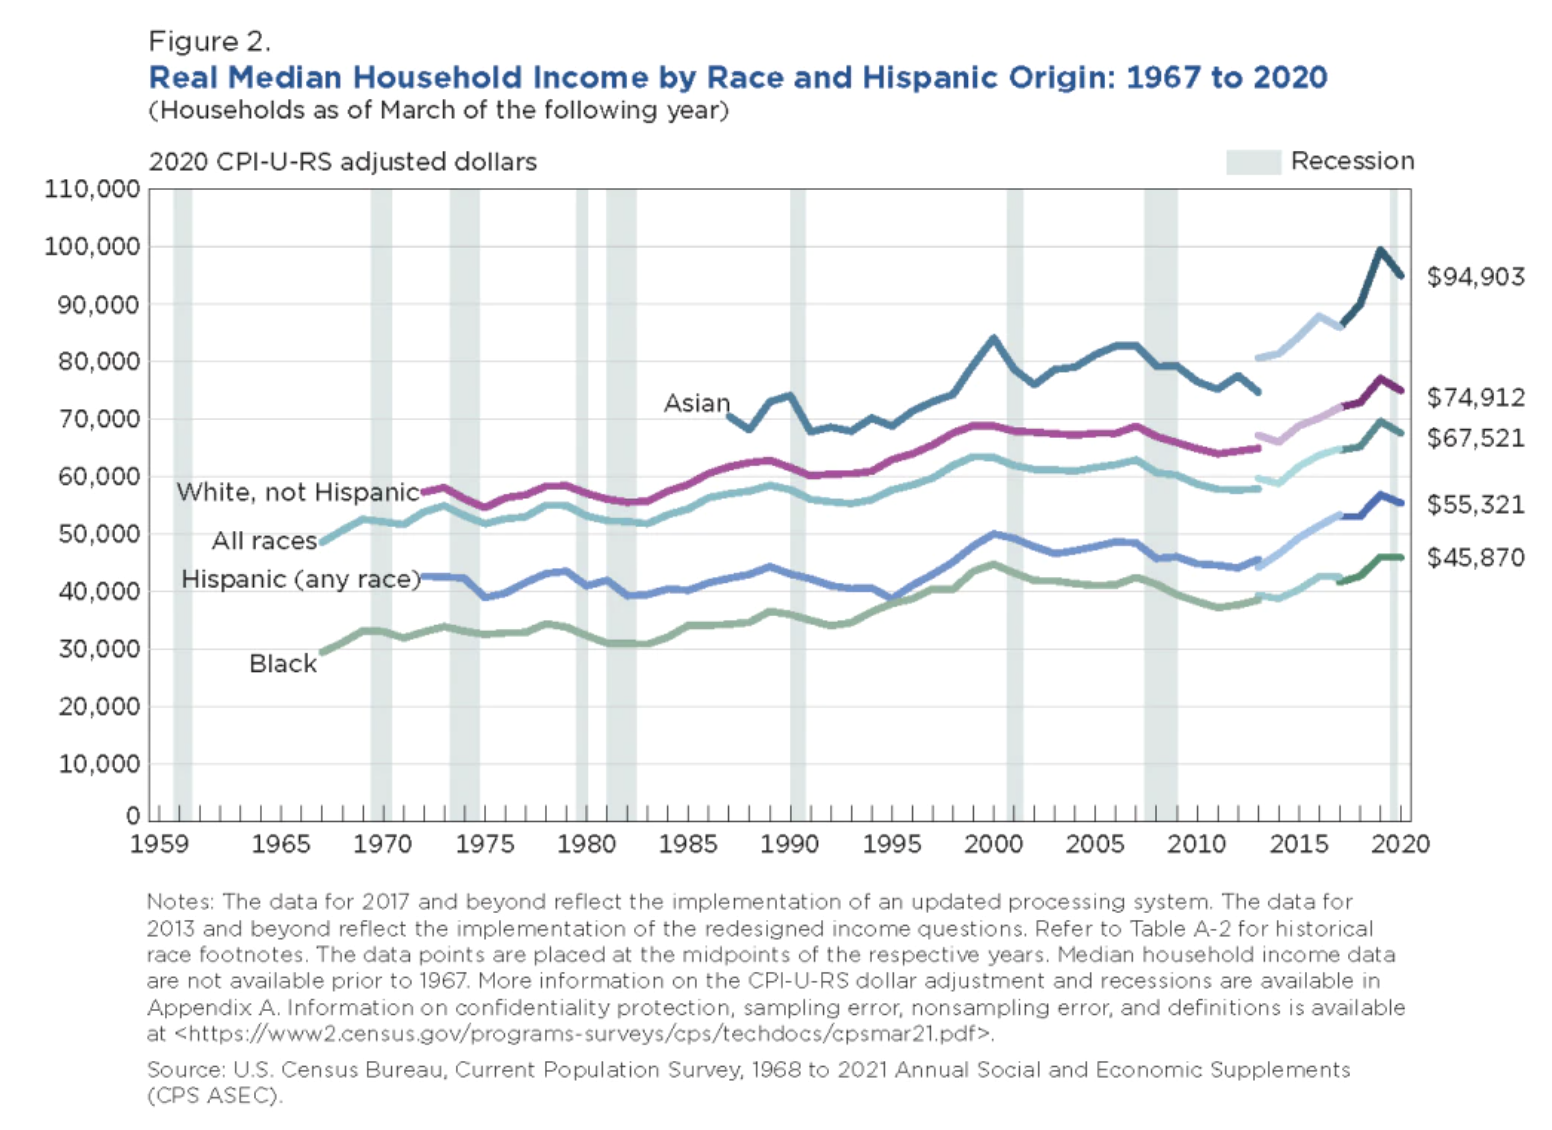

Source: https://www.census.gov/library/visualizations/2021/demo/p60-273.html

#### The IPUMS data differs because it is at the individual level, but it matches the US Census trend.

#### Asian households both are #1, but bottom racial group in terms of median income in the US Census Data is Black

In [15]:
def generate_median_income_plot(model_input):
    
    income_df = model_input[['RACE_Grp','YEAR', 'INCTOT']]
    
    # Calculate mean income by among protected groups by year
    group_pg_year = income_df.groupby(['RACE_Grp','YEAR']).describe().stack(level=0)[['50%','mean']]
    group_pg_year = group_pg_year.reset_index()

    ### The data from IPUMS differs vs. the Census chart above presumably due to household vs. individual level
    income_plot = group_pg_year[['RACE_Grp', 'YEAR', 'mean','50%']]
    income_plot = income_plot.pivot(index='YEAR', columns='RACE_Grp', values='mean')
    income_plot.plot( figsize=(12, 6))

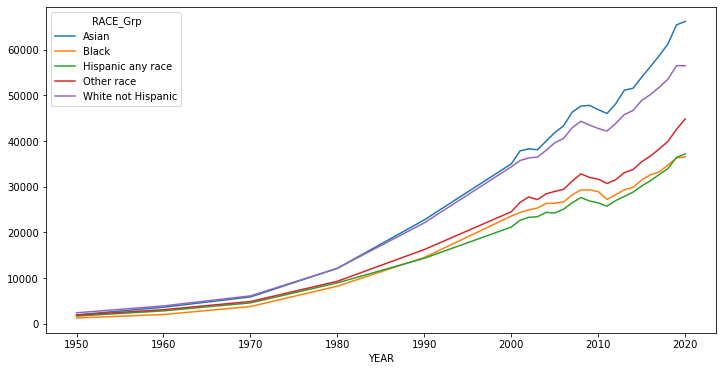

In [16]:
generate_median_income_plot(model_input)

## Info about the data - histograms of age and income over time

In [17]:
# fig = plt.figure(figsize = (15,20))
# ax = fig.gca()
# model_input['AGE'].hist(by=model_input['YEAR_Grp'], ax=ax)


In [18]:
# fig = plt.figure(figsize = (15,20))
# ax = fig.gca()
# model_input['INCTOT'].hist(by=model_input['YEAR_Grp'], ax=ax, bins = 50)


# 4. Create inequality metrics

#### Gini Coefficient


In [19]:
def gini_calc(v):
    
    # Credit where due to user user12446118
    # Link: https://stackoverflow.com/questions/31416664/gini-coefficient-calculation-using-numpy
    
    bins = np.linspace(0., 100., 11)
    total = float(np.sum(v))
    yvals = []
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return bins, yvals, gini_val

# Uncomment to see income distribution histogram and residual vs. perfect eq.
# year_sub = model_input[model_input['YEAR'] == 2020]
# # year_sub.INCTOT.hist(bins = 100)

# bins, result, gini_val = gini_calc(year_sub.INCTOT)

# plt.figure()
# plt.subplot(2, 1, 1)
# plt.plot(bins, result, label="observed")
# plt.plot(bins, bins, '--', label="perfect eq.")
# plt.xlabel("fraction of population")
# plt.ylabel("fraction of wealth")
# plt.title("GINI: %.4f" %(gini_val))
# plt.legend()
# plt.subplot(2, 1, 2)

# v = year_sub.INCTOT

# plt.hist(v, bins=100)

### Create extractors for metrics by segments

In [20]:
# Define 1st inequality metric - Gini coefficient
def ineq_metric_extractor(target_df,group_cols,target):
        # Define gini runner
        def gini_coef(income_array):
            bins, result, gini_val = gini_calc(income_array)
            return gini_val
        
        def percentile(n):
            def percentile_(x):
                return np.percentile(x, n)
            percentile_.__name__ = 'percentile_%s' % n
            return percentile_
        
        # Calculate quantile by among selected groups by year
        out_stats = (target_df.groupby(group_cols)[target]
               .agg([np.mean, percentile(25),percentile(50), percentile(75), 
                     percentile(90), percentile(95), percentile(99), gini_coef]))
        
        return(out_stats)

In [21]:
# Define 1st inequality metric - Gini coefficient
def histogram_extractor(target_df,group_cols,target):
        # Define gini runner
        def gini_coef(income_array):
            bins, result, gini_val = gini_calc(income_array)
            return gini_val
               
        # Calculate quantile by among selected groups by year
        out_stats = (target_df.groupby(group_cols)[target]
               .agg([np.mean, percentile(25),percentile(50), percentile(75), 
                     percentile(90), percentile(95), percentile(99), gini_coef]))
        
        return(out_stats)

In [22]:
# Run all functions with parameter inputs
def scenario_runner(model_input, target, group_cols):
    # Subset fields needed
    all_cols = group_cols + target
    target_df = model_input[all_cols]
    
    # Run function to create stats
    out_stats = ineq_metric_extractor(target_df,group_cols,target)
    
    return(out_stats)

### Select scenarios to run 
### #1: Income & Age: distributions by year 1950 - 2020

In [23]:
def extract_metrics_year(model_input, group_col):
        target_1 = ['INCTOT']
        group_cols_1 = ['YEAR_Grp']

        summary_df_yr_income = scenario_runner(model_input, target_1, group_cols_1)
        
        target_2 = ['AGE']
        summary_df_yr_age = scenario_runner(model_input, target_2, group_cols_1)
        
        target_3 = ['non_white']
        summary_df_yr_minority = pd.DataFrame(model_input.groupby(group_cols_1)[target_3].mean())
        
        # Create function to merge in a single df
        def merge_summary_dfs(summary_df, merge_df):
            merge_df = merge_df.reset_index()
            merge_df.columns = ['_'.join(col).strip() for col in merge_df.columns.values]
            summary_df_new = summary_df.merge(merge_df, left_on='YEAR_Grp', right_on='YEAR_Grp_')

            return(summary_df_new)
        
        # Create all years data and left join summaries of income age and demographics
        summary_df_yr = pd.DataFrame(model_input.groupby(group_cols_1)[target_1].size())
        summary_df_yr = summary_df_yr.reset_index()
        summary_df_yr.columns = ['YEAR_Grp', 'Size']

        # Run function
        summary_df_yr = merge_summary_dfs(summary_df_yr,summary_df_yr_income)
        summary_df_yr = merge_summary_dfs(summary_df_yr,summary_df_yr_age)
        summary_df_yr = summary_df_yr.merge(summary_df_yr_minority, on = 'YEAR_Grp')

        # Clean up duplicated Year columns 
        summary_df_yr = summary_df_yr[summary_df_yr.columns.drop(list(summary_df_yr.filter(regex='YEAR_Grp_')))]
        
        return(summary_df_yr)

In [24]:
summary_df_yr = extract_metrics_year(model_input,'YEAR_Grp')

### #2: Income & Age: distributions by year & MSA 1950 - 2020

In [25]:
def extract_metrics_year(model_input, group_cols):
    target_1 = ['INCTOT']
    summary_df_yr_msa_income = scenario_runner(model_input, target_1, group_cols)

    target_2 = ['AGE']
    summary_df_yr_msa_age = scenario_runner(model_input, target_2, group_cols)

    target_3 = ['non_white']
    summary_df_yr_msa_minority = pd.DataFrame(model_input.groupby(group_cols)[target_3].mean())
    summary_df_yr_msa_minority = summary_df_yr_msa_minority.reset_index()
    summary_df_yr_msa_minority.columns = ['YEAR_Grp','MET2013', 'non_white']

    # Create function to merge in a single df
    def merge_summary_dfs_2(summary_df, merge_df):
        merge_df = merge_df.reset_index()
        merge_df.columns = ['_'.join(col).strip() for col in merge_df.columns.values]
        summary_df_new = summary_df.merge(merge_df, left_on=['YEAR_Grp','MET2013'], right_on=['YEAR_Grp_','MET2013_'])

        return(summary_df_new)

    # Create all years data and left join summaries of income age and demographics
    summary_df_msa = pd.DataFrame(model_input.groupby(group_cols)[target_1].size())
    summary_df_msa = summary_df_msa.reset_index()
    summary_df_msa.columns = ['YEAR_Grp','MET2013', 'Size']

    # Run function
    summary_df_msa = merge_summary_dfs_2(summary_df_msa,summary_df_yr_msa_income)
    summary_df_msa = merge_summary_dfs_2(summary_df_msa,summary_df_yr_msa_age)
    summary_df_msa = summary_df_msa.merge(summary_df_yr_msa_minority, on = ['YEAR_Grp','MET2013'])

    # Clean up duplicated Year columns 
    summary_df_msa = summary_df_msa[summary_df_msa.columns.drop(list(summary_df_msa.filter(regex='YEAR_Grp_')))]
    summary_df_msa = summary_df_msa[summary_df_msa.columns.drop(list(summary_df_msa.filter(regex='MET2013_')))]
    
    return(summary_df_msa)

In [26]:
group_cols = ['YEAR_Grp','MET2013']

summary_df_msa = extract_metrics_year(model_input,group_cols)

In [27]:
# # Left join all metro area names
ipums_metro.columns = ['MET2013','MSA']
msa_flat_out = summary_df_msa.merge(ipums_metro, left_on = 'MET2013', right_on = 'MET2013', how = 'left')

#### Write out all examples for inspection in Tableau

In [28]:
summary_df_yr.to_csv('Tableau/Exhibit 1: Income inequality over time.csv')

# 5. Create MSA-level model variables

#### Explantory variables (at MSA level - 2020): <br>
- X1 - Size
- X2 - Median income
- X3 - % non-white
- X4 - Median age
- X5 - Gini Coeefficient
- X6 - Income IQR
- X7 - Age IQR
<br>

#### Take time diffeences for each variable: <br>
- 2020 / 2000 - Last 20 years - X8 - X14

In [138]:
def lagged_variables_msa(msa_flat_out):

    # Take difference of 2020 and 2000 - first and last years available with all data fields
    msa_table = msa_flat_out[msa_flat_out.YEAR_Grp.isin(['2000', '2020'])]

    msa_table['INCTOT_IQR'] = msa_table['INCTOT_percentile_75'] - msa_table['INCTOT_percentile_25']
    msa_table['AGE_IQR'] = msa_table['AGE_percentile_75'] - msa_table['AGE_percentile_25']

    msa_table['20yr_Delta_Size'] = (msa_table.sort_values('YEAR_Grp').groupby(['MET2013'])['Size']
                       .transform(lambda x: x.pct_change(periods = 1)))

    msa_table['20yr_Delta_MedianIncome'] = (msa_table.sort_values('YEAR_Grp').groupby(['MET2013'])['INCTOT_percentile_50']
                       .transform(lambda x: x.pct_change(periods = 1)))

    msa_table['20yr_Delta_1PercentIncome'] = (msa_table.sort_values('YEAR_Grp').groupby(['MET2013'])['INCTOT_percentile_99']
                       .transform(lambda x: x.pct_change(periods = 1)))

    msa_table['20yr_Delta_NonWhite'] = (msa_table.sort_values('YEAR_Grp').groupby(['MET2013'])['non_white']
                       .transform(lambda x: x.pct_change(periods = 1)))

    msa_table['20yr_Delta_MedianAge'] = (msa_table.sort_values('YEAR_Grp').groupby(['MET2013'])['AGE_percentile_50']
                       .transform(lambda x: x.pct_change(periods = 1)))

    msa_table['20yr_Delta_Gini'] = (msa_table.sort_values('YEAR_Grp').groupby(['MET2013'])['INCTOT_gini_coef']
                       .transform(lambda x: x.pct_change(periods = 1)))

    msa_table['20yr_Delta_IQRIncome'] = (msa_table.sort_values('YEAR_Grp').groupby(['MET2013'])['INCTOT_IQR']
                       .transform(lambda x: x.pct_change(periods = 1)))

    msa_table['20yr_Delta_IQRAge'] = (msa_table.sort_values('YEAR_Grp').groupby(['MET2013'])['AGE_IQR']
                       .transform(lambda x: x.pct_change(periods = 1)))

    return(msa_table)

In [139]:
msa_table = lagged_variables_msa(msa_flat_out)

#### Write out all examples for inspection in Tableau

In [140]:
msa_table['Metropolitan area (2013 OMB delineations)'] = msa_table['MSA']

msa_table.to_csv('Tableau/Exhibit 2: Income inequality by age, race & MSA over time.csv')

In [193]:
# Set all model target and input variables
id_vars = ['YEAR_Grp','MET2013', 'MSA']
dep_var = ['20yr_Delta_Size']
dep_bin = '20yr_Delta_Size'   # Other option 'AB % of Total', 20yr_Delta_MedianIncome

yr_train = '2000'
yr_test = '2020'
            
expl_vars = ['Size','INCTOT_percentile_50','non_white','AGE_percentile_50',
             'INCTOT_gini_coef','INCTOT_IQR','AGE_IQR',
             '20yr_Delta_MedianIncome','20yr_Delta_1PercentIncome','20yr_Delta_NonWhite']
# expl_vars_lagged = msa_table.filter(like='20yr').columns

def model_input_create(id_vars, dep_var, dep_bin, expl_vars, msa_table, msa_donors,yr_train,yr_test):

    # Select all vars created
    msa_df = pd.DataFrame()
    msa_df[expl_vars] = msa_table[expl_vars]
    all_vars_list = msa_df.columns
    
    msa_df[id_vars] = msa_table[id_vars]

    msa_df_train = msa_df[msa_df['YEAR_Grp'] == yr_train]

    # Join dependent variable
    # Conservatism - model 1
#     msa_model_df = msa_df.merge(msa_donors[['MSA','AB % of Total']], left_on = 'MSA',right_on = 'MSA')

    # Median income growth - model 2
    msa_df_test = msa_table[msa_table['YEAR_Grp'] == yr_test]
    all_vars = id_vars + dep_var
    msa_df_test = msa_df_test[all_vars]

    msa_model_df = msa_df_train.merge(msa_df_test, on = 'MSA')
    
    return(msa_model_df, all_vars_list)

In [194]:
msa_model_df,all_vars_list = model_input_create(id_vars, dep_var, dep_bin, expl_vars, msa_table, msa_donors,yr_train,yr_test)

#### We also group data by region for future modeling purposes

In [195]:
def group_by_region(msa_model_df):

    msa_model_df['State'] = msa_model_df.MSA.str.split(',', expand=True)[1].str[1:3]
    
    # Make a list with each of the regions by state.
    west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
    south_west = ['AZ', 'TX', 'NM', 'OK']
    south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
    mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
    north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

    msa_model_df['Region'] = np.nan

    def finding_regions(state):
        if state in west:
            return 'West'
        elif state in south_west:
            return 'SouthWest'
        elif state in south_east:
            return 'SouthEast'
        elif state in mid_west:
            return 'MidWest'
        elif state in north_east:
            return 'NorthEast'

    msa_model_df['Region'] = msa_model_df['State'].apply(finding_regions)

    return(msa_model_df)

In [196]:
msa_model_df = group_by_region(msa_model_df)

# 6. Build political leanings model

#### Target (Y): 
- Y1 - Ratio of political donations between Actblue and WinRed
- Y2 - Total $ donations to small-donor political causes

### RAI Framework

In [197]:
def model_df_prep(model_sample,num_vars,cat_vars):
    
    def normalize_num(df, num_cols):
        """
        This function normalizes numeric variables

        Args:
            df: pandas df with numeric columns to normalize
            num_cols: list of numeric column names

        Result:
            Returns same dataframe with normalized data
        """

        x = df[num_cols].values  # returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        df_num = pd.DataFrame(x_scaled)
        df_num.columns = num_cols
        df_num = df_num.reset_index(drop=True)

        df_drop = df.drop(num_cols, axis=1)
        df_drop = df_drop.reset_index(drop=True)
        df_final = pd.concat([df_drop, df_num], axis=1)

        return df_final


    # This is an internal function which one-hot encodes all categorical and normalizes all numeric variables
    model_data_norm = normalize_num(model_sample, num_vars)
    model_data_cat = pd.get_dummies(model_sample[cat_vars])
    model_data_num = model_data_norm[num_vars]
    model_data = pd.concat([model_data_norm[[dep_bin]], model_data_cat, model_data_num], axis=1)

    # Print shape of final machine-learning ready data frame
    print("Model data shape: ", model_data.shape)

    model_data = model_data.fillna(0)
    
    return(model_data)

In [200]:
# Rename current msa-level model input. w/ 
model_sample = msa_model_df

# Select all variables to include
print(all_vars_list)

num_vars = all_vars_list
cat_vars = 'Region'

# Run function
model_data = model_df_prep(model_sample,num_vars,cat_vars)

print(model_data.columns)

Index(['Size', 'INCTOT_percentile_50', 'non_white', 'AGE_percentile_50',
       'INCTOT_gini_coef', 'INCTOT_IQR', 'AGE_IQR', '20yr_Delta_MedianIncome',
       '20yr_Delta_1PercentIncome', '20yr_Delta_NonWhite'],
      dtype='object')
Model data shape:  (231, 16)
Index(['20yr_Delta_Size', 'MidWest', 'NorthEast', 'SouthEast', 'SouthWest',
       'West', 'Size', 'INCTOT_percentile_50', 'non_white',
       'AGE_percentile_50', 'INCTOT_gini_coef', 'INCTOT_IQR', 'AGE_IQR',
       '20yr_Delta_MedianIncome', '20yr_Delta_1PercentIncome',
       '20yr_Delta_NonWhite'],
      dtype='object')


# Boruta + SHAP Model Interpretation Framework

In [201]:
## Conventional
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from datetime import datetime
import os

# Facet
from facet.data import Sample
from facet.inspection import LearnerInspector
from facet.selection import LearnerRanker, LearnerGrid
from facet.crossfit import LearnerCrossfit

# sklearn
from sklearn.compose import make_column_selector
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor

# sklearndf: Instead of using the "regular" scikit-learn package, we are using the `sklearndf`
# (see on [GitHub](https://github.com/orgs/BCG-Gamma/sklearndf/)) wrapper which keeps metadata
# such as column names when passing the data through the scikit-learn learners.
from sklearndf.pipeline import PipelineDF, RegressorPipelineDF
from sklearndf.regression import (
    RandomForestRegressorDF,
    ExtraTreesRegressorDF,
    LinearRegressionDF,
    RidgeDF,
)
from sklearndf.regression.extra import LGBMRegressorDF
from sklearndf.transformation.extra import BorutaDF
from sklearndf.transformation import (
    ColumnTransformerDF,
    OneHotEncoderDF,
    SimpleImputerDF,
)

# if want not to see warnings
import warnings
warnings.filterwarnings("ignore")

In [202]:
# create sample object
msa_sample = Sample(
    observations=model_data,
    feature_names=model_data.drop(columns=[dep_bin]).columns,
    target_name=dep_bin,
)

# check target name
msa_sample.target_name

'20yr_Delta_Size'

In [203]:
## Preprocessing pipeline

# for categorical features we will use the mode as the imputation value and also one-hot encode
preprocessing_categorical = PipelineDF(
    steps=[
        ("imputer", SimpleImputerDF(strategy="most_frequent", fill_value="<na>")),
        ("one-hot", OneHotEncoderDF(sparse=False, handle_unknown="ignore")),
    ]
)

# for numeric features we will impute using the median
preprocessing_numerical = SimpleImputerDF(strategy="mean")

# put the pipeline together
preprocessing = ColumnTransformerDF(
    transformers=[
        (
            "categorical",
            preprocessing_categorical,
            make_column_selector(dtype_include=object),
        ),
        (
            "numerical",
            preprocessing_numerical,
            make_column_selector(dtype_include=np.number),
        ),
    ]
)

## Feature selection

boruta_pipeline = PipelineDF(
    [
        ("preprocessing", preprocessing),
        ("boruta", BorutaDF(
            estimator=RandomForestRegressorDF(max_depth=7, random_state=42, n_jobs=-2),
            n_estimators="auto",
            perc=66,
            random_state=0,
            verbose=2,
        ))
    ]
)

boruta_pipeline.fit(X=msa_sample.features, y=msa_sample.target)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	7
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	7
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	7
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	7
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	7
Iteration: 	13 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	7
Iteration: 	14 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	7
Iteration: 	15 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	7
Iteration: 	16 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	7
Iteration:

PipelineDF(steps=[('preprocessing',
                   ColumnTransformerDF(transformers=[('categorical',
                                                      PipelineDF(steps=[('imputer',
                                                                         SimpleImputerDF(fill_value='<na>',
                                                                                         strategy='most_frequent')),
                                                                        ('one-hot',
                                                                         OneHotEncoderDF(handle_unknown='ignore',
                                                                                         sparse=False))]),
                                                      <sklearn.compose._column_transformer.make_column_selector object at 0x7fd02c6cfd90>),
                                                     ('numerical',
                                                      SimpleImputerDF(),
 

In [204]:
pd.set_option('display.max_rows', None)
boruta_pipeline.feature_names_original_.to_frame()

,feature_in
feature_out,
West,West
INCTOT_percentile_50,INCTOT_percentile_50
non_white,non_white
AGE_percentile_50,AGE_percentile_50
INCTOT_gini_coef,INCTOT_gini_coef
INCTOT_IQR,INCTOT_IQR


In [205]:
selection = boruta_pipeline.feature_names_original_.unique()

msa_confirmed = msa_sample.keep(feature_names=selection)

## Manually add back a few categorical variables

# MatrixDrawer(style="matplot%").draw(data=fractionation_confirmed.features.join(fractionation_confirmed.target).corr(method="spearman"), title="redundancy matrix")

# fractionation_df.corr()

# test_df = boruta_pipeline.feature_names_original_.to_frame()
# test_df['feature_in'].unique()

## Model fitting
grids = [
    LearnerGrid(
        pipeline=RegressorPipelineDF(
            preprocessing=preprocessing, 
            regressor=ExtraTreesRegressorDF(n_estimators=400, random_state=42),
        ), 
        learner_parameters={
            "min_samples_leaf": [1, 2, 4], 
            "max_depth": [None, 10, 20]
        }
        ), 
#     LearnerGrid(
#         pipeline=RegressorPipelineDF(
#             preprocessing=preprocessing,
#             regressor=RidgeDF(),
#         ),
#         learner_parameters={
#             "alpha": [1, 0.1, 0.01, 0.001, 0.0001]
#         }
#     ),
    LearnerGrid(
        pipeline=RegressorPipelineDF(
            preprocessing=preprocessing,
            regressor=LinearRegressionDF(),
        ),
        learner_parameters={
            "normalize": [True, False]
        }
    ),
    # add extratrees
    LearnerGrid(
        pipeline=RegressorPipelineDF(
            preprocessing=preprocessing,
            regressor=LGBMRegressorDF(n_estimators=400, random_state=42),
        ),
        learner_parameters={
            "min_child_samples": [2, 4],
#             "learning_rate": [1, 0.1, 0.01] 
            "max_depth": [2, 3, 4, 7]
        }
    ),
    LearnerGrid(
        pipeline=RegressorPipelineDF(
            preprocessing=preprocessing,
            regressor=RandomForestRegressorDF(n_estimators=200, random_state=42),
        ),
        learner_parameters={
            "min_samples_leaf": [1, 2, 4],
            "max_depth": [2, 4, None]
        }
    )
]

In [206]:
ranker = LearnerRanker(
    grids=grids,
    cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=0),
    n_jobs=-2,
    verbose=10,
    scoring="r2",
)

ranker.fit(msa_confirmed)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-2)]: Done  39 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-2)]: Done  50 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-2)]: Done  63 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-2)]: Done  76 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-2)]: Done  91 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-2)]: Done 106 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-2)]: Done 123 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-2)]: Done 140 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-2)]: Done 159 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-2)]: Done 178 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-2)]: Done 199 tasks      | elapsed:  

In [207]:
ranker.summary_report()

ranking_score        r2                          regressor  \
                        mean       std                     type   
rank                                                              
0         0.026175  0.247617  0.110721  RandomForestRegressorDF   
1         0.010918  0.260780  0.124931  RandomForestRegressorDF   
2         0.010021  0.235408  0.112694  RandomForestRegressorDF   
3        -0.008576  0.162880  0.085728  RandomForestRegressorDF   
4        -0.016001  0.256400  0.136201  RandomForestRegressorDF   
5        -0.019915  0.241550  0.130732  RandomForestRegressorDF   
6        -0.021824  0.134738  0.078281  RandomForestRegressorDF   
7        -0.031161  0.180533  0.105847  RandomForestRegressorDF   
8        -0.042867  0.234200  0.138534  RandomForestRegressorDF   
9        -0.064034  0.246653  0.155344    ExtraTreesRegressorDF   
10       -0.066055  0.246360  0.156208    ExtraTreesRegressorDF   
11       -0.066055  0.246360  0.156208    ExtraTreesRegressorDF   
12       -0.110118  0.243284  0.176701    ExtraTreesRegressorDF   
13       -0.110154  0.243266  0.176710    ExtraTreesRegressorDF   
14       -0.112252  0.245937  0.179095    ExtraTreesRegressorDF   
15       -0.125635  0.236278  0.180956    ExtraTreesRegressorDF   
16       -0.156542  0.222786  0.189664    ExtraTreesRegressorDF   
17       -0.159780  0.222220  0.191000    ExtraTreesRegressorDF   
18       -0.177137  0.187801  0.182469       LinearRegressionDF   
19       -0.177137  0.187801  0.182469       LinearRegressionDF   
20       -0.238846  0.167658  0.203252          LGBMRegressorDF   
21       -0.275355  0.153126  0.214240          LGBMRegressorDF   
22       -0.283912  0.176087  0.229999          LGBMRegressorDF   
23       -0.306111  0.139257  0.222684          LGBMRegressorDF   
24       -0.307433  0.126964  0.217199          LGBMRegressorDF   
25       -0.316683  0.147400  0.232042          LGBMRegressorDF   
26       -0.332366  0.091719  0.212042          LGBMRegressorDF   
27       -0.442962  0.070101  0.256531          LGBMRegressorDF   

                                                             
     min_samples_leaf max_depth normalize min_child_samples  
rank                                                         
0                 2.0       4.0       NaN               NaN  
1                 4.0       4.0       NaN               NaN  
2                 1.0       4.0       NaN               NaN  
3                 2.0       2.0       NaN               NaN  
4                 4.0       NaN       NaN               NaN  
5                 2.0       NaN       NaN               NaN  
6                 1.0       2.0       NaN               NaN  
7                 4.0       2.0       NaN               NaN  
8                 1.0       NaN       NaN               NaN  
9                 4.0      10.0       NaN               NaN  
10                4.0       NaN       NaN               NaN  
11                4.0      20.0       NaN               NaN  
12                2.0      20.0       NaN               NaN  
13                2.0       NaN       NaN               NaN  
14                2.0      10.0       NaN               NaN  
15                1.0      10.0       NaN               NaN  
16                1.0      20.0       NaN               NaN  
17                1.0       NaN       NaN               NaN  
18                NaN       NaN      True               NaN  
19                NaN       NaN     False               NaN  
20                NaN       2.0       NaN               2.0  
21                NaN       3.0       NaN               4.0  
22                NaN       2.0       NaN               4.0  
23                NaN       4.0       NaN               4.0  
24                NaN       4.0       NaN               2.0  
25                NaN       3.0       NaN               2.0  
26                NaN       7.0       NaN               2.0  
27                NaN       7.0       NaN               4.0

In [208]:
# Features importance
ins = LearnerInspector().fit(ranker.best_model_crossfit_)
ins.feature_importance().sort_values(ascending=False)

feature
AGE_percentile_50       0.297494
INCTOT_percentile_50    0.281828
West                    0.155624
non_white               0.140860
INCTOT_gini_coef        0.081741
INCTOT_IQR              0.042453
Name: 20yr_Delta_Size, dtype: float64

#### Run linear model - measure coefficients

#### Output all model preds and residuals

# 7. Interpret model drivers and results

In [209]:
model_data[dep_var].describe()

,20yr_Delta_Size
count,231.000000
mean,-0.792239
std,0.040952
min,-0.870750
25%,-0.820292
50%,-0.794601
75%,-0.772097
max,-0.547051


In [185]:
model_data_binary = model_data

model_data_binary['high_growth'] = np.where(model_data_binary[dep_var] >.6,1,0)

model_data_binary = model_data_binary.drop(labels=dep_var, axis=1)

model_data_binary['high_growth'].value_counts(normalize=True)

0    0.688312
1    0.311688
Name: high_growth, dtype: float64

In [186]:
dep_var_binary = 'high_growth'

In [187]:
X = model_data_binary.drop(labels=dep_var_binary, axis=1)

y = model_data_binary[dep_var_binary]

features = X.columns
cat_features = []
for cat in X.select_dtypes(exclude="number"):
    cat_features.append(cat)
#   think about meaningful ordering instead
    X[cat] = X[cat].astype("category").cat.codes.astype("category")

X_train, X_val, y_train, y_val = train_test_split(X,y,train_size=.8, random_state=42)

clf = LGBMClassifier(max_depth=3, n_estimators=1000, objective="binary")
clf.fit(X_train,y_train, eval_set=(X_val,y_val), early_stopping_rounds=100, verbose=100) 

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.583896
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.527037


LGBMClassifier(max_depth=3, n_estimators=1000, objective='binary')

In [188]:
X.columns

Index(['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West', 'Size',
       'INCTOT_percentile_50', 'non_white', 'AGE_percentile_50',
       'INCTOT_gini_coef', 'INCTOT_IQR', 'AGE_IQR', '20yr_Delta_Size',
       '20yr_Delta_1PercentIncome', '20yr_Delta_NonWhite'],
      dtype='object')

In [189]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)
sv = np.array(shap_values)
y = clf.predict(X_train).astype("bool")
# shap values for high income
sv_target = sv[:,y,:]
# shap values for not high income
sv_nontarget = sv[:,~y,:]

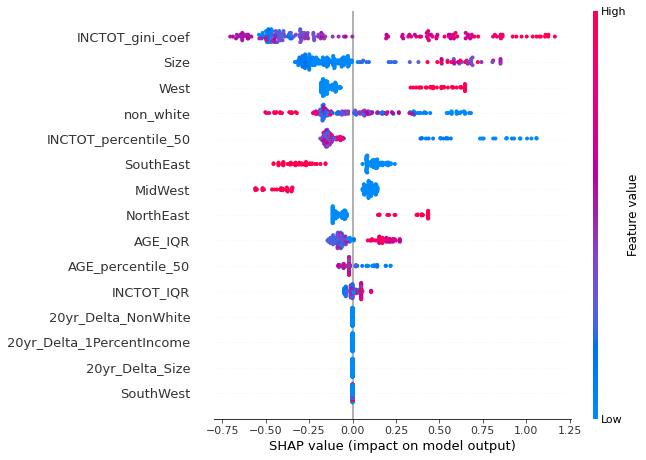

In [190]:
# Variable importance plot - how to read
# Age = normalized age, higher = higher chance of high income
# Sex = categorical variable, male = higher chance of high income
# Educ 11 = 5+ years of college = higher chance of high income
# Mortgage = higher = higher chance of high income
shap.summary_plot(shap_values[1], X_train.astype("float"))

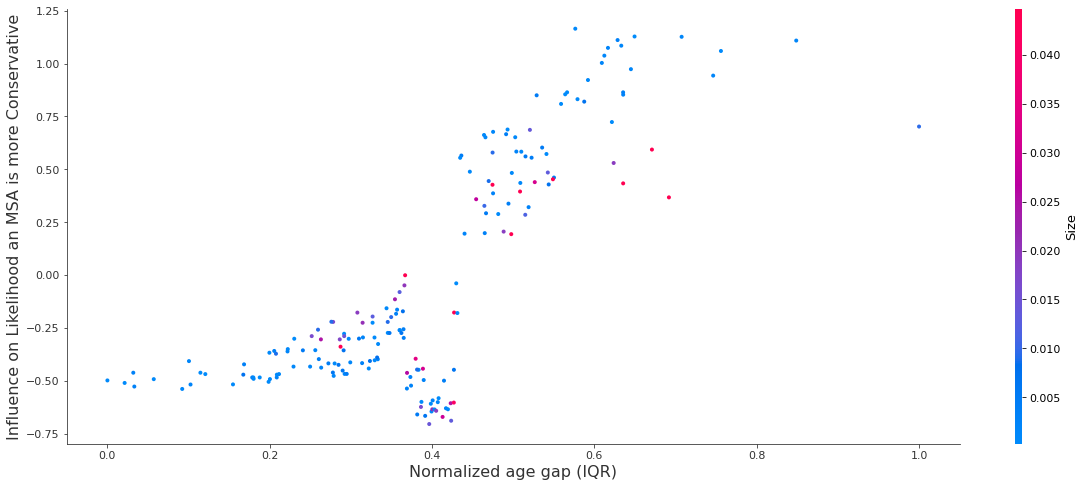

In [192]:
#### Best for understanding a smaller segment on x-axis - only <4 levels
shap_2 = shap.dependence_plot("INCTOT_gini_coef", shap_values[1], X_train, show = False)
shap_2
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(20)
ax = plt.gca()
ax.set_xlabel(r'Normalized age gap (IQR)', fontsize=16)
ax.set_ylabel('Influence on Likelihood an MSA is more Conservative', fontsize=16)
plt.show()

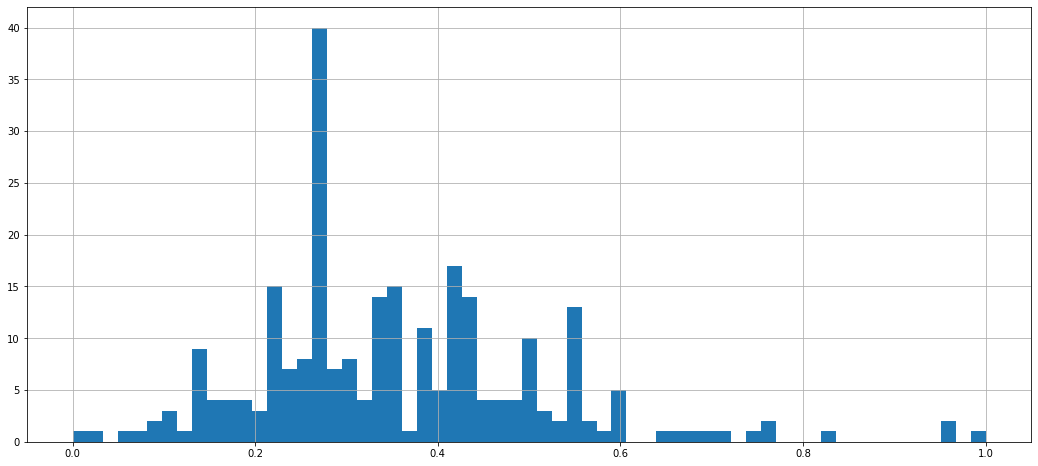

In [112]:
# Distribution of full population - model_input n = 5 MM / year, model_sample n = 20k
model_data.INCTOT_percentile_50.hist(bins = 61)
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(18)

###### Update April 28th, 2022

- Created Google Sheet with varaible info
- Created ntiles of income by city / metro area
- Join with mapping of metropolitan area (2013) to zipcodes
- Tabulate income deciles for each metro area

###### Update May 29th, 2022
- Pulled data back to 1880


###### To be added
- Racial proportions by MSA per year
- Switch to bias against a protected group
- Show how predictions skew for eeach PG with and without certain variables
- Add log loss or another model performance metric to compare instead of accuracy / confusion matrix outputs

#### Steps for individual income model
4. Develop political leanings model & evaluate driver variables
5. Build individual-level features (DNA)
6. Develop income model & evaluate driver variables
7. Create model bias scorecard

### Create feature for income relative to metropolitan area

In [ ]:
model_input['income_rank_in_region'] = model_input.groupby('MET2013')['INCTOT'].rank(ascending=True,pct=True)

### Create a binary target variables

In [ ]:
model_input['high_income'] = np.where(model_input.income_rank_in_region >= .95,1,0)
model_input['high_income'].value_counts(normalize=True)

### Quick check if there is gender bias

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

year_sex = model_input[['YEAR', 'SEX','INCTOT']]
year_sex = year_sex.groupby(['YEAR', 'SEX']).median()

In [ ]:
### Variables of interest

# SEX	AGE	MARST	RACE
# SPEAKENG	SCHOOL	EDUC	EDUCD	GRADEATT	GRADEATTD	SCHLTYPE	
# INCTOT	FTOTINC	INCWAGE
# POVERTY
# CBHHTYPE
# RENT MORTGAGE
# VALUEH

### Input parameters

In [ ]:
# set parameters for bias check
dependent = 'high_income'  # dependent variable we measure
protected_group = 'SEX'  # protected group for which we compare outcomes
outcome_advantage = 1
pg_disadvantage = 0 ## this is the class we want to test for whether an advantage exists
dependent_bin = 'high_income_target'
thresh_min = .6
thresh_max = 1

# set additional parameters for the toy model [skip if you have your own model]
target_rate = .95  # target_rate = 1 - desired (target) positive rate, i.e., outome rate: percentage of the population that classified as predicted outcome 1.
test_size = .4
random_state = 777
n_estimators = 400
bias_detect_thresh = .2
data_name = 'income_dataset'

### 01 - Bias Index Check

In [ ]:
bias_checker = DataBiasChecker(pvalue_threshold=0.1, 
                               test_type="z-test",
                               is_2_sided=False)

In [ ]:
pg = model_sample[protected_group]
y = model_data[dependent_bin]

bias_checker.fit(pg, y)

In [ ]:
bias_checker.biased_

In [ ]:
bias_checker.p_value_

In [ ]:
bias_checker.historic_crosstab_

In [ ]:
# Historical bias index
bias_checker.historic_crosstab_[1][2]/bias_checker.historic_crosstab_[1][1]
# 0.384

### 03 - Fairness Scenarios

In [ ]:
bias_ranker = ModelBiasRanker(best_estimator,
                              pos_rate=0.1,
                              bias_tolerance=0.2)

In [ ]:
pg_train.value_counts()

In [ ]:
bias_ranker.fit(X_train, y_train, pg_train)

In [ ]:
bias_ranker.results_

In [ ]:
bias_handler = ModelBiasHandler(best_estimator,
                                pos_rate=0.1,
                                bias_tolerance=0.2,
                                method="demog_parity")

In [ ]:
bias_handler.fit(X_train, y_train, pg_train)

In [ ]:
bias_handler.non_pg_rate_

In [ ]:
bias_handler.pg_rate_

In [ ]:
bias_handler.predict(X_train, pg_train)

In [ ]:
# Steps Ahead:
# - unit tests
# - exception handling